# 二极管基础知识复习

In [1]:
%matplotlib inline
%load_ext tikzmagic

from math import exp, log, log10
import numpy as np
from matplotlib import pyplot as plt
import ngspyce as ng

# kΩ μA

def para(r1, r2):
  return (r1*r2) / (r1 + r2)

## Shockley 公式

William Shockley 于 1949/07 在 BSTJ 发表了 "The theory of p-n junctions in semiconductors and p-n junction transistors" https://ieeexplore.ieee.org/document/6773080
$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$

$\li{D}=\ui{S}\Big(\exp\dfrac{\lv{D}}{n \uv{T}}-1\Big)\approx\ui{S}\exp\dfrac{\lv{D}}{n \uv{T}}$

$\uv{D} - \ui{D}$ 呈指数关系，如果 $n=1$，那 $\uv{D}$ 每增加 60mV，$\ui{D}$ 增大 10 倍，因为 $60 / 26\approx 2.3$, $e^{2.3}\approx 10$.

| $\ui{D}\propto \exp \uv{D}$    | $\ui{S}=0.1\mathrm{fA}$ | $\ui{S}=1\mathrm{fA}$ |  $\ui{S}=10\mathrm{fA}$ | 
| --- | --- | --- | --- |
| $\uv{D}=0.64$V | 0.00576 mA | 0.0576 mA | 0.576 mA |
| $\uv{D}=0.70$V | 0.0576 mA | 0.576 mA | 5.76 mA |
| $\uv{D}=0.76$V | 0.576 mA | 5.76 mA | 57.6mA |

In [7]:
Vt = 25.865

# import tabulate ?
print('           Id =', end='')
for I in [0.001, 0.01, 0.1, 1]:
    print('%4.0f mA  ' % (I * 1000), end='')
print()

#for Is in [1e-11, 1e-12, 1e-13, 1e-14, 1e-15]:
for Is in [1e-15, 1e-14, 1e-13, 1e-12, 1e-11]:
    print('Is = %g A ' % Is, end='')
    for I in [0.001, 0.01, 0.1, 1]:
        print("  %4.0f mV" % (Vt * log(I / Is)), end='')
    print()

           Id =   1 mA    10 mA   100 mA  1000 mA  
Is = 1e-15 A    715 mV   774 mV   834 mV   893 mV
Is = 1e-14 A    655 mV   715 mV   774 mV   834 mV
Is = 1e-13 A    596 mV   655 mV   715 mV   774 mV
Is = 1e-12 A    536 mV   596 mV   655 mV   715 mV
Is = 1e-11 A    476 mV   536 mV   596 mV   655 mV


这个指数关系高度非线性，简单的工作点就不好算。解析解要用 [Lambert _W_ 函数](https://en.wikipedia.org/wiki/Lambert_W_function)，一般模拟电路书上不会讲。

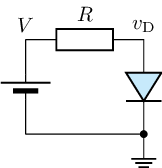

In [2]:
%%tikz -ct

\ctikzset{european resistors}
\ctikzset{diodes/fill=cyan!20}

\draw (0, 0) node [above] {$V$}
  to [battery2] ++(0, -1.6) coordinate (G);
\draw (0, 0) to [R, l={$R$}, bipoles/length=1.2cm] ++(2, 0)
  node [above] {$v_\mathrm{D}$}
  to [D, bipoles/length=1.2cm] ++(0, -1.6)
  node [circ] {} node [ground] {}
  -- (G);

In [8]:
ng.circ('''
  V  vcc  0  1V
  R  vcc  d  1k
  D  d    0  D
  .model D D(IS=1fA)
''')
ng.operating_point()

{'v#branch': array([-0.00031519]),
 'd': array([0.68481116]),
 'vcc': array([1.])}

近似估算 $\uv{D}\approx 0.7\,$V，$\ui{D}=\dfrac{1-0.7}{1\,\mathrm{k}\Omega}=0.3$mA，与仿真结果相去不远。

## 小信号模型

$\sm{r}{d}=\dfrac{\lv{d}}{\li{d}}$

小信号计算 $\Delta \lv{D}=5.2$mV @ $\ui{D}=1$mA, $\Delta \li{D}=\dfrac{5.2}{26}=0.2$mA.

大信号计算 $\Delta \li{D}= \ui{S}\Big(\exp\dfrac{\uv{D}+\Delta\lv{D}}{\uv{T}}-\exp\dfrac{\uv{D}}{\uv{T}}\Big)=\ui{D}\Big(\exp\dfrac{\Delta\lv{D}}{\uv{T}}-1\Big) = 0.2214$mA

利用 Taylor 展开，对于 PN 节的指数特性，一般教材认为 $\lv{i}\le 5$mV 算小信号。

$\sm{r}{d}=\dfrac{\Delta \lv{D}}{\Delta \li{D}}=\dfrac{\uv{T}}{\ui{D}}$，即 $\sm{r}{d}\propto \dfrac{1}{\ui{D}}$，换言之电流越大，$\sm{r}{d}$ 越小。

| $\uv{T}=26\mathrm{mV}$ | $\sm{r}{d}$ |
| --- | --- |
| $\ui{D}=0.1$mA | $\sm{r}{d}=260\,\Omega$ |
| $\ui{D}=1$mA | $\sm{r}{d}=26\,\Omega$ |
| $\ui{D}=10$mA | $\sm{r}{d}=2.6\,\Omega$ |
| $\ui{D}=100$mA | $\sm{r}{d}=0.26\,\Omega$ |

In [8]:
exp(5.2/26)-1

0.22140275816016985

In [12]:
print('Error %.2f %%' % (100 * (0.2/0.2214-1)))

Error -9.67 %


In [32]:
for vd in [0.1, 0.2, 0.5, 1, 2, 5, 10]:
    Vt = 26
    actual = exp(vd / Vt) - 1
    estimate = vd / Vt
    print('vd = %4.1f mV, error = %5.2f %%' % (vd, 100 * abs(estimate / actual-1)))

vd =  0.1 mV, error =  0.19 %
vd =  0.2 mV, error =  0.38 %
vd =  0.5 mV, error =  0.96 %
vd =  1.0 mV, error =  1.91 %
vd =  2.0 mV, error =  3.80 %
vd =  5.0 mV, error =  9.31 %
vd = 10.0 mV, error = 18.00 %


**SPICE**

In [2]:
ng.circ('''
  D anode 0 D
  V anode 0 DC 0.7V AC SINE(0.7 10m 1k)
  .model D D(IS=10fA)
''')
ng.operating_point()

{'v#branch': array([-0.00567035]), 'anode': array([0.7])}

这里为了展示失真，特意取 $\lv{i}=10$mV.

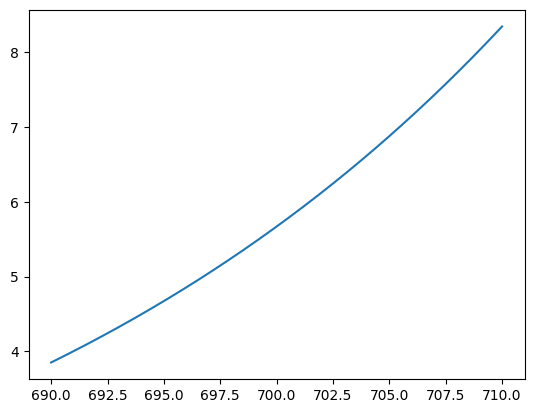

In [6]:
ng.cmd('dc v 0.69 0.71 10u')
Vd = 1e3*ng.vector('anode')
Id = -1e3 * ng.vector('v#branch')
plt.plot(Vd, Id)

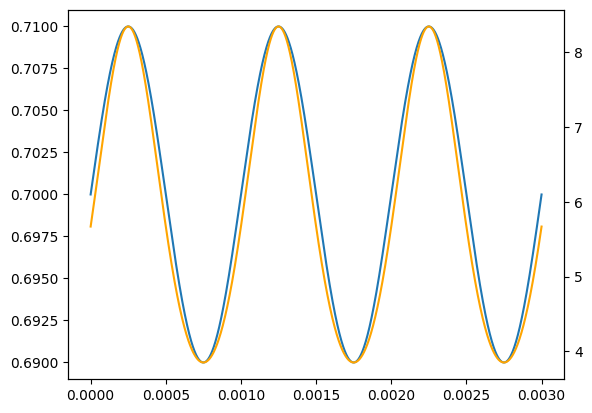

In [18]:
ng.cmd('tran 1u 3m')
t = ng.vector('time')
Vd = ng.vector('anode')
Id = -1e3 * ng.vector('v#branch')
fig, ax = plt.subplots()
plt.plot(t, Vd)
ax2 = ax.twinx()
plt.plot(t, Id, 'orange')

为了更明显看到非线性失真，用三角波做输入信号。

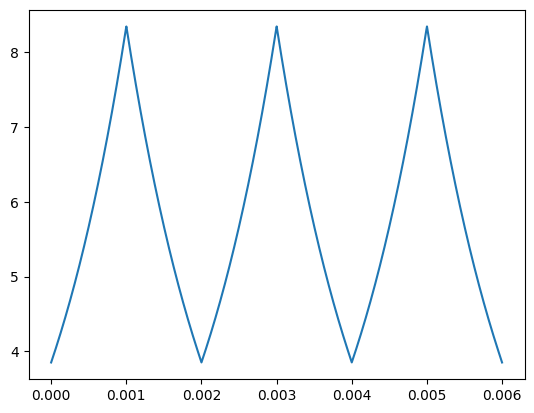

In [34]:
ng.circ('''
  V anode 0 PULSE(0.69V 0.71V 0 1m 1m 1u 2m)
  D anode 0 D
  .model D D(IS=10fA)
''')
ng.cmd('tran 1u 6m')
plt.plot(ng.vector('time'), -1e3*ng.vector('v#branch'))

小信号例子

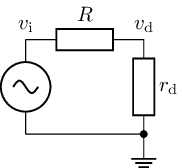

In [13]:
%%tikz -ct

\ctikzset{american voltages, european resistors}

\draw (0, 0) node [above] {$v_\mathrm{i}$}
  to [sV] ++(0, -1.6) coordinate (G);
\draw (0, 0) to [R, l={$R$}, bipoles/length=1.2cm] ++(2, 0)
  node [above] {$v_\mathrm{d}$}
  to [R, l={$r_\mathrm{d}$}, bipoles/length=1.2cm] ++(0, -1.6)
  node [circ] {} node [ground] {}
  -- (G);

$R=1\,$kΩ，$\uv{D}\approx 0.7\,$V，$\ui{D}\approx 0.3\,$mA, $\sm{r}{d}=\dfrac{\uv{T}}{\ui{D}}=86.7\,\Omega$

$\lv{i}=10\,$mV，$\lv{d}=\dfrac{\sm{r}{d}}{R+\sm{r}{d}} \lv{i}=\dfrac{86.7}{1000 + 86.7}\lv{i}=0.798\,$mV

In [25]:
ng.circ('''
  V  vcc  0  DC 1V SINE(1V 10mV 1k)
  R  vcc  d  1k
  D  d    0  D
  .model D D(IS=1fA)
''')
ng.operating_point()

{'v#branch': array([-0.00031519]),
 'd': array([0.68481116]),
 'vcc': array([1.])}

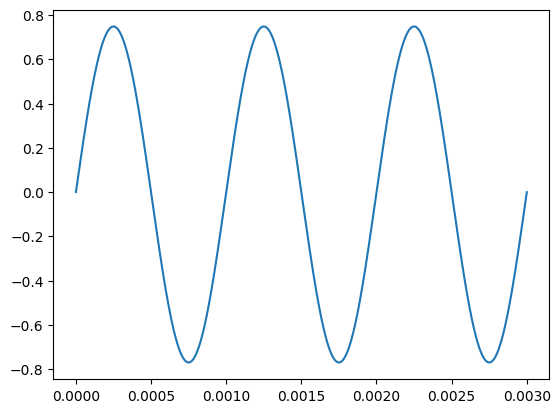

In [26]:
ng.cmd('tran 1u 3m')
t = ng.vector('time')
Vin = ng.vector('vcc')
Vd = ng.vector('d')
Id = -1e3 * ng.vector('v#branch')
fig, ax = plt.subplots()
# plt.plot(t, Vin)
plt.plot(t, 1e3*(Vd - 0.6848112))
#ax2 = ax.twinx()
#plt.plot(t, Vd, 'orange')

## 温度特性

https://en.wikipedia.org/wiki/Silicon_bandgap_temperature_sensor

## Schottky 二极管

## 发光二极管 LED

In [16]:
ng.circ('''
  I1 0 vd 10mA
  D1 vd 0 LED
  .model LED D(Is=1e-22 n=1.5)
  ''')
ng.operating_point()

{'vd': array([1.78668524])}

## 整流滤波电路

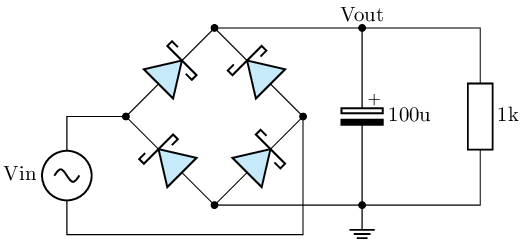

In [17]:
%%tikz -ct
\ctikzset{european resistors, american voltages, diodes/fill=cyan!20}

\draw (0, 0) to [sDo] ++(1.5, 1.5) coordinate (VP);
\draw (0, 0) to [sDo, invert, mirror] ++(1.5, -1.5) coordinate (G);
\draw (G) to [sDo] ++(1.5, 1.5) coordinate (B)
  to [sDo] (VP)
  to [short, *-] ++(2.5, 0) coordinate (C)
  node [above] {Vout}
  to [eC, l={100u}] (C |- G) coordinate (CN)
  node [ground] {}
  to [short, -*] (G);
\draw (C) to [short, *-] ++(2, 0) coordinate (R)
  to [R, l=1k] (R |- G)
  to [short, -*] (CN);
\draw (0, 0) to [short, *-] ++(-1, 0)
  to [sV, l_={Vin}] ++(0, -2) coordinate (VS)
  to [short] (VS -| B)
  to [short, -*] (B);

## 稳压二极管

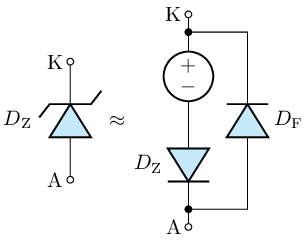

In [12]:
%%tikz -ct
\ctikzset{american voltages, american currents, diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20}

\draw (0, -1) node [left] {A} to [zzD,n=ZD, l=$D_\mathrm{Z}\;$, o-o] ++(0, 2) node [left] {K};
\draw (ZD) ++(0.8, 0) node [open] {$\approx$};
\draw (2, 1.8) node [left] {K} to [short, o-] ++(0, -0.3) coordinate (A)
to [V] ++(0, -1.5) coordinate(M) to [D, l_=$D_\mathrm{Z}$] ++(0, -1.5) coordinate (K)
to [short, -o] ++(0, -0.3)  node [left] {A};
\draw (K) to [short, *-] ++(1, 0) to [D, l_=$D_\mathrm{F}$] ++(0, 3) to [short, -*] (A);
%\draw [dashed] (M) -- (ZD);

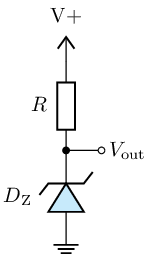

In [13]:
%%tikz -ct
\ctikzset{american voltages, american currents, european resistors, diodes/fill=cyan!20}

\draw (0, -1) node [tlground] {}
  to [zzD,n=ZD, l=$D_\mathrm{Z}\;$, bipoles/length=1.2cm] ++(0, 1.6)
  coordinate (OUT)
  to [R, l={$R\;$}, bipoles/length=1cm] ++(0, 1.5)
  node [vcc] {V+};

\draw (OUT) to [short, *-o] ++(0.6, 0) node [right] {$V_\mathrm{out}$};

### 温度补偿

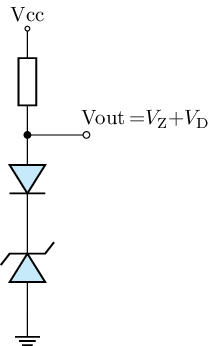

In [10]:
%%tikz -ct
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, european resistors}
\draw (0, 0) node [above] {Vcc}
  to [R, o-, bipoles/length=1.0cm] ++(0, -1.8)
  coordinate (A) 
  to [D, bipoles/length=1.2cm] ++(0, -1.5)
  to [zzD, invert, mirror, bipoles/length=1.2cm] ++(0, -1.5)
  node [ground] {}; 
\draw (A) to [short, *-o] ++(1, 0) ++(1,0) node [above] {Vout\,=\uv{Z}+\uv{D}};

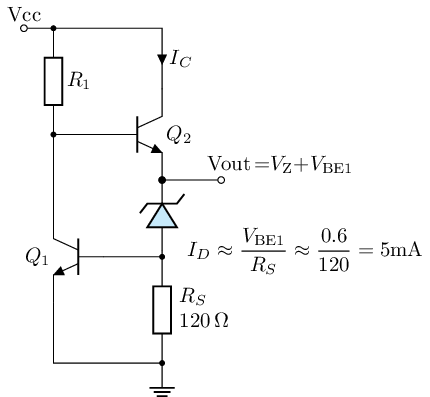

In [5]:
%%tikz -ct -p amsmath

\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, european resistors}
\draw (0, 0) node [above] {Vcc}
    to [short, o-] ++(0.5, 0) coordinate(A)
    to [R, *-*, l={$R_1$}, bipoles/length=1.0cm] ++(0, -1.8) coordinate (B)
    to [short] ++(1.0, 0)
    node [npn, anchor=B] (Q1) {$Q_2$};
\draw (A) to [short] (A-|Q1.C) to [short,i={$I_C$}] (Q1.C);
\draw (Q1.E) to [short, *-o] ++(1, 0) ++(1,0) node [above] {Vout\,=\uv{Z}+\uv{BE1}};
\draw (Q1.E)
    to [zzD, invert, mirror, bipoles/length=1cm] ++(0, -1.2) coordinate (D);
\draw (B) to [short] ++(0, -1.3) node[npn, anchor=C, xscale=-1] (Q2) {};
\draw (Q2) node[left=-2pt] {$Q_1$};
\draw (Q2.B) -| (D);
\draw (Q2.B -| Q1.E) to [R, l2={$R_S$ and $120\,\Omega$}, *-*, bipoles/length=1.0cm] ++(0, -1.8) coordinate(G) node[ground]{};
\draw (Q2.E) |- (G);
\draw (D)++(0.3, 0) node [right] {$I_D \approx\dfrac{\uv{BE1}}{R_S}\approx \dfrac{0.6}{120}=5$mA};